In [1]:
%load_ext autoreload
%autoreload 2

This notebook will closely follow the [Simulating Molecules using VQE Qiskit Tutorial](https://qiskit.org/textbook/ch-applications/vqe-molecules.html). 

Our goal is to estimate the ground state energy $\lambda_{\text{min}}$ of some Hamiltonian $H$. 

By the variational principle, we know the below is true for some quantum state $|\psi (\vec{\theta})\rangle$ of norm 1, where $\vec{\theta}$ represent parameters that we can set to realize any valid quantum state.

$$ \left\langle \psi(\vec{\theta})  \right| H \left| \psi(\vec{\theta}) \right\rangle = \sum_{\lambda_i,\lambda_j} \langle \psi(\vec{\theta}) | \psi_{\lambda_i} \rangle \langle \psi_{\lambda_i} | H | \psi_{\lambda_j} \rangle \langle \psi_{\lambda_j} | \psi(\vec{\theta}) \rangle$$

$$\left\langle \psi(\vec{\theta})  \right| H \left| \psi(\vec{\theta}) \right\rangle = \sum_{\lambda} \lambda |\langle \psi_{\lambda} | \psi(\vec{\theta}) \rangle |^2$$

$$\left\langle \psi(\vec{\theta})  \right| H \left| \psi(\vec{\theta}) \right\rangle \geq \lambda_{\text{min}} \sum_{\lambda}  |\langle \psi_{\lambda} | \psi(\vec{\theta}) \rangle|^2 = \lambda_{\text{min}}$$ 

We also know that for $|\psi (\vec{\theta_{\text{min}}})\rangle = |\psi_{\text{min}}\rangle$ (the ground state eigenfunction), we satisy the above inequality. 

Thus, we must
1. Find some way to construct an eigenfunction $|\psi (\vec{\theta})\rangle$.
2. Optimize over the $\vec{\theta}$ to minimize $\langle \psi(\vec{\theta})  | H | \psi(\vec{\theta}) \rangle$ and find the lowest upper bound to $\lambda_{\text{min}}$. 

With this motivation in mind, let's begin with the simplest case of a 1 qubit Hilbert space. Here, we can access any arbitrary quantum state by applying the $U_3$ gate on an arbitrary intial state $\left|\psi_0\right\rangle$, namely $\left|\psi (\vec{\theta})\right\rangle = U_3(\theta_1,\theta_2, \theta_3)\left|\psi_0\right\rangle$ where 

$$U_3(\vec{\theta}) = \begin{pmatrix} \cos\left(\frac{\theta_1}{2}\right) & -e^{i \theta_3} \sin\left(\frac{\theta_1}{2}\right)\\e^{i\theta_2}\sin\left(\frac{\theta_1}{2}\right)& e^{i\theta_3 + i\theta_2}\cos\left(\frac{\theta_1}{2}\right)\end{pmatrix}$$

Now that we have defined $\left|\psi (\vec{\theta})\right\rangle$ we can minimize the $\left\langle \psi(\vec{\theta})  \right| H \left| \psi(\vec{\theta}) \right\rangle$ matrix over $\vec{\theta}$. The classical optimizer we will use to do this will first use the _Constrained Optimization by Linear Approximation optimizer_ (COBYLA) optimizer in the noiseless case, and the _Simultaneous Perturbation Stochastic Approximation_ (SPSA) optimizer for a noisy simulator. 

### Example 
#### _(ground state energy of random single qubit Hermitian operator)_

##### measuring < psi | H | psi>

To orient the reader, we begin by demonstrating how to find $\langle \psi | H | \psi \rangle$ using Qiskit. While one could simply take the matematical overlap, this approach quickly becomes computationally inefficient for larger systems. Instead, we estimate $\langle \psi | H | \psi \rangle$ using multiple shots of an executed quantum circuit. In the example below, we take the expectation of the $H_2$ hydrogen molecule hamiltonian against the $\left|0\right\rangle$ qubit state. 

In [2]:
from qiskit import QuantumCircuit, execute, Aer
from qiskit.aqua import QuantumInstance
from qiskit.aqua.operators import PauliExpectation, CircuitStateFn, CircuitSampler, StateFn
from qiskit.aqua.operators import MatrixExpectation, AerPauliExpectation
from qiskit.aqua.operators import X, Y, Z, I
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=3)

In [3]:
# H2-molecule Hamiltonian 
op =  (-1.0523732 * I^I) + (0.39793742 * I^Z) + (-0.3979374 * Z^I) \
    + (-0.0112801 * Z^Z) + (0.18093119 * X^X)

In [4]:
# define the state you w.r.t. which you want the expectation value
psi = QuantumCircuit(2)
# convert to a state
psi = CircuitStateFn(psi)

In [5]:
# "Mathematical" < psi | O | psi > 
print('Math:', psi.adjoint().compose(op).compose(psi).eval().real)

Math: -1.06365328


In [6]:
# Shot-based Results

backend = Aer.get_backend('qasm_simulator') 
q_instance = QuantumInstance(backend, shots=1024)

# define the state to sample
measurable_expression = StateFn(op, is_measurement=True).compose(psi) 

# convert to expectation value
expectations = {}
expectations['shots'] = PauliExpectation().convert(measurable_expression)
expectations['aer'] = AerPauliExpectation().convert(measurable_expression)
expectations['matrix'] = MatrixExpectation().convert(measurable_expression)

samplers = {}
for label, expectation  in expectations.items():
    samplers[label] = CircuitSampler(q_instance).convert(expectations[label]) 

# evaluate
for label, sampler  in samplers.items():
    print(label + ": ", sampler.eval().real)  

shots:  -1.061886373847656
aer:  -1.06365328
matrix:  -1.06365328


And so, we see that `AerPauliExpectation` and `MatrixExpectation` are exact methods, while `PauliExpectation` uses shots. 

##### optimization using 1 qubit

Here, we define a random Hermitian operator $H$ within a 1-qubit Hilbert Space and use the variational principle to find the ground state energy `lambda_min` of $H$. 

In [7]:
backend = Aer.get_backend('qasm_simulator') 
q_instance = QuantumInstance(backend, shots=1024)

# setup random hermitian 
np.random.seed(0)
rand_coeff = np.random.randn(4)
op = rand_coeff[0]*I + rand_coeff[1]*X + rand_coeff[2]*Y + rand_coeff[3]*Z
op_np = op.to_matrix()

def get_var_circuit(params):
    qr = QuantumRegister(1, name="q")
    psi_qc = QuantumCircuit(qr)
    psi_qc.u(params[0], params[1], params[2], qr[0])
    return psi_qc

def get_measurable_expression(params):
    psi_qc = get_var_circuit(params)
    psi_qc = CircuitStateFn(psi_qc)
    return StateFn(op, is_measurement=True).compose(psi_qc) 
    
def objective_function(params):
    # Obtain a quantum circuit instance from the paramters
    measurable_expression = get_measurable_expression(params)
    expectation = AerPauliExpectation().convert(measurable_expression)
    sampler = CircuitSampler(q_instance).convert(expectation)
    return sampler.eval().real

print(objective_function([0.1,.1,2]))

4.04325469422588


In [8]:
from qiskit.aqua.components.optimizers import COBYLA

# Initialize the COBYLA optimizer
optimizer = COBYLA(maxiter=500, tol=0.0001)

# Create the initial parameters (noting that our single qubit variational form has 3 parameters)
params = np.random.rand(3)
ret = optimizer.optimize(num_vars=3, objective_function=objective_function, initial_point=params)


# Obtain the output distribution using the final parameters
lambda_min = objective_function(ret[0])


# comparison of Ground State Energy
print("Parameters Found: ", ret[0])
print("\nGround State Energy (vqe): {:.8f}".format(lambda_min))
v,w = np.linalg.eigh(op_np)
print("Ground State Energy (exact): {:.8f}".format(v[0]))
print("Percent difference: " + str((lambda_min - v[0])/np.abs(v[0])*100) + "%")

# comparison of Ground State
backend_statevector = Aer.get_backend('statevector_simulator')
ground_state_vqe_qc = get_var_circuit(ret[0])
ground_state_exact = w[:,0] # take first eigenvector
result = execute(ground_state_vqe_qc,backend_statevector).result()
ground_state_vqe = result.get_statevector()

print("\nGround State (vqe): \n", ground_state_vqe)
print("Ground State (exact): \n", ground_state_exact)
ground_state_vqe_qc.draw()

Parameters Found:  [3.582 1.183 0.247]

Ground State Energy (vqe): -0.71378060
Ground State Energy (exact): -0.71378061
Percent difference: 1.1044281950047938e-06%

Ground State (vqe): 
 [-0.219+0.j     0.369+0.903j]
Ground State (exact): 
 [-0.219-0.j     0.369+0.903j]


┌──────────────────────────┐
q_0: ┤ U(3.5824,1.1826,0.24673) ├
     └──────────────────────────┘

The VQE algorithm finds a pretty reasonable (~$10^{-6}$% above exact eigenvalue) ground state energy as desired!

### Example 
#### _(ground state energy of two Qubit H$_2$ Hydrogen Molecule)_

Here, we define a the H$_2$ Hydrogen Molecule hamiltonian $H$ within a 2-qubit Hilbert Space and use the variational principle to find the ground state energy `lambda_min` of $H$. The 2 qubit variational circuit used to create $\left|\psi(\vec{\theta})\right\rangle$ is based on the work presented by _Shende et al._ \[2\] and covered in the Simulating Molecules using VQE Qiskit Tutorial \[1\].

In [9]:
backend = Aer.get_backend('qasm_simulator') 
q_instance = QuantumInstance(backend, shots=1024)

# setup random hermitian 
np.random.seed(0)
rand_coeff = np.random.randn(16)
op =  (-1.0523732 * I^I) + (0.39793742 * I^Z) + (-0.3979374 * Z^I) \
    + (-0.0112801 * Z^Z) + (0.18093119 * X^X)

op_np = op.to_matrix()


def get_var_circuit(params):
    qr = QuantumRegister(2, name="q")
    psi_qc = QuantumCircuit(qr)
    psi_qc.u(params[0], params[1], params[2], qr[0])
    psi_qc.u(params[3], params[4], params[5], qr[1])
    psi_qc.cx(qr[1], qr[0])
    
    psi_qc.u(params[6], params[7], params[8], qr[0])
    psi_qc.u(params[9], params[10], params[11], qr[1])
    psi_qc.cx(qr[0], qr[1])
    
    psi_qc.u(params[12], params[13], params[14], qr[0])
    psi_qc.u(params[15], params[16], params[17], qr[1])
    psi_qc.cx(qr[1], qr[0])
    
    psi_qc.u(params[18], params[19], params[20], qr[0])
    psi_qc.u(params[21], params[22], params[23], qr[1])
    return psi_qc

def get_measurable_expression(params, plot=False):
    psi_qc = get_var_circuit(params)
    if plot:
        print(psi_qc)
    psi_qc = CircuitStateFn(psi_qc)
    return StateFn(op, is_measurement=True).compose(psi_qc) 
    
def objective_function(params, plot=False):
    # Obtain a quantum circuit instance from the paramters
    measurable_expression = get_measurable_expression(params, plot=plot)
    expectation = AerPauliExpectation().convert(measurable_expression)
    sampler = CircuitSampler(q_instance).convert(expectation)
    return sampler.eval().real

print(objective_function(np.random.randn(24), plot=True))

     ┌────────────────────────────┐┌───┐ ┌────────────────────────────┐      »
q_0: ┤ U(1.4941,-0.20516,0.31307) ├┤ X ├─┤ U(0.86444,-0.74217,2.2698) ├───■──»
     ├───────────────────────────┬┘└─┬─┘┌┴────────────────────────────┴┐┌─┴─┐»
q_1: ┤ U(-0.8541,-2.553,0.65362) ├───■──┤ U(-1.4544,0.045759,-0.18718) ├┤ X ├»
     └───────────────────────────┘      └──────────────────────────────┘└───┘»
«       ┌──────────────────────────┐ ┌───┐┌────────────────────────────┐
«q_0: ──┤ U(1.5328,1.4694,0.15495) ├─┤ X ├┤ U(-0.34791,0.15635,1.2303) ├
«     ┌─┴──────────────────────────┴┐└─┬─┘├────────────────────────────┤
«q_1: ┤ U(0.37816,-0.88779,-1.9808) ├──■──┤ U(1.2024,-0.38733,-0.3023) ├
«     └─────────────────────────────┘     └────────────────────────────┘
-0.7172682562928445


In [10]:
from qiskit.aqua.components.optimizers import COBYLA

# Initialize the COBYLA optimizer
optimizer = COBYLA(maxiter=500, tol=0.0001)

# Create the initial parameters (noting that our single qubit variational form has 3 parameters)
params = np.random.rand(24)
ret = optimizer.optimize(num_vars=24, objective_function=objective_function, initial_point=params)


# Obtain the output distribution using the final parameters
lambda_min = objective_function(ret[0])

# comparison of Ground State Energy
print("\nGround State Energy (vqe): {:.9f}".format(lambda_min))
v,w = np.linalg.eigh(op_np)
print("Ground State Energy (exact): {:.9f}".format(v[0]))
print("Percent difference: " + str((lambda_min - v[0])/np.abs(v[0])*100) + "%")

# comparison of Ground State
backend_statevector = Aer.get_backend('statevector_simulator')
ground_state_vqe_qc = get_var_circuit(ret[0])
ground_state_exact = w[:,0] # take first eigenvector
result = execute(ground_state_vqe_qc,backend_statevector).result()
ground_state_vqe = result.get_statevector()
print("\nGround State (vqe): \n", ground_state_vqe[:,None])
print("Ground State (exact): \n", ground_state_exact[:,None])
ground_state_vqe_qc.draw(fold=300)


Ground State Energy (vqe): -1.857274956
Ground State Energy (exact): -1.857274958
Percent difference: 1.0313009276567964e-07%

Ground State (vqe): 
 [[ 2.627e-06-4.436e-05j]
 [-1.426e-01+9.835e-01j]
 [ 1.600e-02-1.104e-01j]
 [ 2.180e-06+1.150e-05j]]
Ground State (exact): 
 [[ 1.003e-16+0.j]
 [ 9.938e-01+0.j]
 [-1.115e-01+0.j]
 [-6.654e-16+0.j]]


┌───────────────────────────┐┌───┐ ┌───────────────────────────┐        ┌──────────────────────────┐  ┌───┐┌───────────────────────────┐ 
q_0: ┤ U(0.14172,0.3048,0.55437) ├┤ X ├─┤ U(0.14171,1.3299,0.79466) ├───■────┤ U(1.223,0.19922,0.55497) ├──┤ X ├┤ U(0.79602,1.0491,0.84788) ├─
     ├───────────────────────────┤└─┬─┘┌┴───────────────────────────┴┐┌─┴─┐┌─┴──────────────────────────┴─┐└─┬─┘├───────────────────────────┴┐
q_1: ┤ U(1.4704,2.2581,0.099753) ├──■──┤ U(-0.04374,0.44868,0.23005) ├┤ X ├┤ U(-0.077896,0.16094,0.35685) ├──■──┤ U(0.054411,1.1242,0.53814) ├
     └───────────────────────────┘     └─────────────────────────────┘└───┘└──────────────────────────────┘     └────────────────────────────┘

Again, the VQE algorithm finds a pretty reasonable (~$10^{-7}$% above exact eigenvalue) ground state energy as desired!

### Example 
#### _(ground state energy of LiH with varying atomic distance)_

The next perhaps most demonstrative example of VQE capabilities will involve calculating the ground state energy of LiH with varying interatomic distance. Here, we will use both the capabilities of Qiskit Chemistry and Qiskit Aqua.

In [11]:
# Imports needed for basic no noise VQE simulation
import numpy as np
import copy
from qiskit import BasicAer
from qiskit.aqua import aqua_globals, QuantumInstance
from qiskit.aqua.algorithms import NumPyMinimumEigensolver, VQE
from qiskit.aqua.components.optimizers import SLSQP, SPSA
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.drivers import PySCFDriver
from qiskit.chemistry.core import Hamiltonian, QubitMappingType
from tqdm import tqdm

import matplotlib.pyplot as plt

# Some deprecated package issue; one warning is enough.
import warnings
# warnings.filterwarnings(action='once')
warnings.filterwarnings('ignore')

Numpy 1.16 has memory leak bug  https://github.com/numpy/numpy/issues/13808
It is recommended to downgrade to numpy 1.15 or older


In [12]:
molecule = 'H .0 .0 -{0}; Li .0 .0 {0}' # Define molecule; could be H2 or LiH, etc.
distances = np.arange(0.5, 3.75, 0.25) # Distances in Angstrom
vqe_energies = [] 
hf_energies = [] # Hartree-Fock energies
exact_energies = [] # Exact energies from numerical diagonalization

In [14]:
for i in tqdm(range(len(distances))):
    d = distances[i]
    # set up experiment
    driver = PySCFDriver(molecule.format(d/2), basis='sto3g')
    qmolecule = driver.run()
    operator = Hamiltonian(qubit_mapping=QubitMappingType.PARITY, 
                           two_qubit_reduction=True, freeze_core=True,
                           orbital_reduction=[-3, -2]) # Approxns needed to make this
                                                       # problem tractable.
    
    qubit_op, aux_ops = operator.run(qmolecule)
    
    # exact classical result
    exact_result = NumPyMinimumEigensolver(qubit_op, aux_operators=aux_ops).run()
    exact_result = operator.process_algorithm_result(exact_result)
    
    # VQE
    optimizer = SLSQP(maxiter=1000)
    initial_state = HartreeFock(operator.molecule_info['num_orbitals'],
                                operator.molecule_info['num_particles'],
                                qubit_mapping=operator._qubit_mapping,
                                two_qubit_reduction=operator._two_qubit_reduction)
    
    var_form = UCCSD(num_orbitals=operator.molecule_info['num_orbitals'],
                     num_particles=operator.molecule_info['num_particles'],
                     initial_state=initial_state,
                     qubit_mapping=operator._qubit_mapping,
                     two_qubit_reduction=operator._two_qubit_reduction)
    
    algo = VQE(qubit_op, var_form, optimizer, aux_operators=aux_ops)
    
    vqe_result = algo.run(QuantumInstance(BasicAer.get_backend('statevector_simulator')))
    vqe_result = operator.process_algorithm_result(vqe_result)
    
    exact_energies.append(exact_result.energy)
    vqe_energies.append(vqe_result.energy)
    hf_energies.append(vqe_result.hartree_fock_energy)

100%|██████████| 13/13 [00:38<00:00,  2.98s/it]


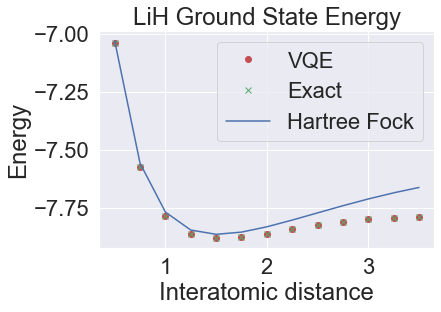

In [15]:
import seaborn as sns
sns.set_theme()
sns.set(font_scale=2)

plt.plot(distances, vqe_energies, 'o', color='r',label='VQE')
plt.plot(distances, exact_energies, 'x', color='g', label='Exact')
plt.plot(distances, hf_energies, color='b',label='Hartree Fock')

plt.xlabel('Interatomic distance')
plt.ylabel('Energy')
plt.title('LiH Ground State Energy')
plt.legend(loc='upper right')

# Uncomment to save plot! 
#plt.savefig('vqe.png', dpi=300)

### Example 
#### _(ground state energy of H-H with varying atomic distance)_

We can similarly calculate the ground state energy of the H$_2$ molecule with varying atomic distance. 

In [16]:
from qiskit.aqua.algorithms import VQE, NumPyEigensolver
import matplotlib.pyplot as plt
import numpy as np
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.circuit.library import EfficientSU2
from qiskit.aqua.components.optimizers import COBYLA, SPSA, SLSQP
from qiskit.aqua.operators import Z2Symmetries
from qiskit import IBMQ, BasicAer, Aer
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry import FermionicOperator
from qiskit import IBMQ
from qiskit.aqua import QuantumInstance
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel

In [17]:
molecule = 'H .0 .0 -{0}; H .0 .0 {0}' # Define molecule; could be H2 or LiH, etc.
distances = np.arange(0.25, 4.0, 0.25) # Distances in Angstrom
vqe_energies = [] 
exact_energies = [] # Exact energies from numerical diagonalization
hf_energies = []

In [18]:
backend = BasicAer.get_backend("statevector_simulator")
for i in tqdm(range(len(distances))):
    d = distances[i]
    
    # set up experiment
    driver = PySCFDriver(molecule.format(d/2),  unit=UnitsType.ANGSTROM, charge=0, spin=0, basis='sto3g')
    qmolecule = driver.run()
    num_particles = qmolecule.num_alpha + qmolecule.num_beta
    operator = Hamiltonian(qubit_mapping=QubitMappingType.PARITY, 
                           two_qubit_reduction=True) # Approxns needed to make this
                                                       # problem tractable.
    
    qubitOp, auxOps = operator.run(qmolecule)
    
    # exact classical result
    exact_solution = NumPyEigensolver(qubitOp).run()
    exact_result = np.real(exact_solution.eigenvalues) + qmolecule.nuclear_repulsion_energy
    
    # VQE
    optimizer = SLSQP(maxiter=1000)
    num_spin_orbitals = qmolecule.num_orbitals * 2
    initial_state = HartreeFock(num_spin_orbitals,
                                num_particles,
                                qubit_mapping='parity',
                                two_qubit_reduction=True)
    
    var_form = UCCSD(num_orbitals=num_spin_orbitals,
                     num_particles=num_particles,
                     initial_state=initial_state,
                     qubit_mapping='parity',
                     two_qubit_reduction=True)
    
    vqe = VQE(qubitOp, var_form, optimizer, aux_operators=auxOps)
    vqe_result = vqe.run(QuantumInstance(BasicAer.get_backend('statevector_simulator')))
    vqe_result = operator.process_algorithm_result(vqe_result)
    
    exact_energies.append(exact_result)
    vqe_energies.append(vqe_result.energy)
    hf_energies.append(vqe_result.hartree_fock_energy)

100%|██████████| 15/15 [00:11<00:00,  1.31it/s]


In [21]:
''' Another way!
backend = BasicAer.get_backend("statevector_simulator")
for i, d in tqdm(enumerate(distances)):    
    # set up experiment
    driver = PySCFDriver(molecule.format(d/2),  unit=UnitsType.ANGSTROM, charge=0, spin=0, basis='sto3g')
    qmolecule = driver.run()
    num_particles = qmolecule.num_alpha + qmolecule.num_beta
    qubitOp = FermionicOperator(h1=qmolecule.one_body_integrals, h2=qmolecule.two_body_integrals).mapping(map_type='parity')
    qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles)
    
    # exact classical result
    exact_solution = NumPyEigensolver(qubitOp).run()
    exact_result = np.real(exact_solution.eigenvalues) + qmolecule.nuclear_repulsion_energy
    
    
    optimizer = SPSA(maxiter=100)
    var_form = EfficientSU2(qubitOp.num_qubits, entanglement="linear")
    vqe = VQE(qubitOp, var_form, optimizer=optimizer)
    vqe_result = np.real(vqe.run(backend)['eigenvalue'] + qmolecule.nuclear_repulsion_energy)
    
    exact_energies.append(exact_result)
    vqe_energies.append(vqe_result)
'''
print("")

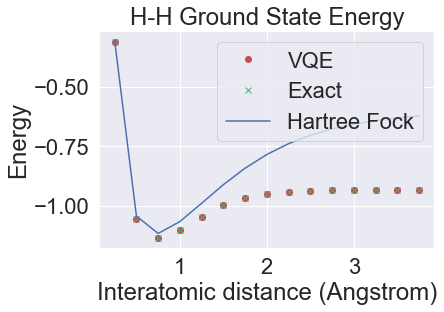

In [20]:
import seaborn as sns
sns.set_theme()
sns.set(font_scale=2)

plt.plot(distances, vqe_energies, 'o', color='r',label='VQE')
plt.plot(distances, exact_energies, 'x', color='g', label='Exact')
plt.plot(distances, hf_energies, color='b',label='Hartree Fock')


plt.xlabel('Interatomic distance (Angstrom)')
plt.ylabel('Energy')
plt.title('H-H Ground State Energy')
plt.legend(loc='upper right')

# Uncomment to save plot! 
#plt.savefig('vqe.png', dpi=300)

### Example with Noise
#### _(ground state energy of H-H with varying atomic distance)_

We can add noise and error mitigation into our quantum circuit and again calculate the ground state energy of the H$_2$ molecule with varying atomic distance. 

**References:**
1. [Simulating Molecules using VQE, Qiskit Tutorial](https://qiskit.org/textbook/ch-applications/vqe-molecules.html)
2. Shende, Vivek V., Igor L. Markov, and Stephen S. Bullock. "Minimal universal two-qubit cnot-based circuits." arXiv preprint quant-ph/0308033 (2003).